In [1]:
from datasets.humanml import HumanML3D

In [2]:
train_dataset = HumanML3D(root='data/v4.3-wall-humanML3d-2136', frames_per_clip=16, num_points=2048, train=True)
test_dataset = HumanML3D(root='data/v4.3-wall-humanML3d-2136', frames_per_clip=16, num_points=2048, train=False)

In [3]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 23008
Test dataset size: 4314


In [4]:
train_data = train_dataset[0]
test_data = test_dataset[0]
print(f'Train data sample shape: {train_data[0].shape}')
print(f'Test data sample shape: {test_data[0].shape}')
print(f'Train data sample caption: {train_data[1]}')
print(f'Test data sample caption: {test_data[1]}')

Train data sample shape: (16, 2048, 3)
Test data sample shape: (16, 2048, 3)
Train data sample caption: a man squats extraordinarily low then bolts up in an unsatisfactory jump
Test data sample caption: a man kicks something or someone with his left leg


# Dataset Analysis for Hyperparameter Tuning

This notebook analyzes the HumanML3D dataset to determine optimal training parameters:
- **Spatial radius**: For point cloud neighborhood search
- **Number of samples (nsamples)**: Points to sample in each radius
- **Spatial/temporal stride**: Downsampling factors
- **Point cloud statistics**: Distribution of points, spatial extent, temporal dynamics

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Basic Dataset Statistics

In [6]:
print(f"Train sequences: {len(train_dataset)}")
print(f"Test sequences: {len(test_dataset)}")
print(f"Total sequences: {len(train_dataset) + len(test_dataset)}")
print(f"\nFrames per clip: {train_dataset.frames_per_clip}")
print(f"Points per frame: {train_dataset.num_points}")

Train sequences: 23008
Test sequences: 4314
Total sequences: 27322

Frames per clip: 16
Points per frame: 2048


## 2. Spatial Extent Analysis

Analyze the spatial extent of point clouds to determine appropriate **radius** for neighborhood search.

In [7]:
# Sample random sequences and compute spatial statistics
num_samples = min(100, len(train_dataset))
sample_indices = np.random.choice(len(train_dataset), num_samples, replace=False)

spatial_stats = {
    'min_coords': [],
    'max_coords': [],
    'range': [],
    'mean_distance_to_centroid': [],
    'std_distance_to_centroid': []
}

print("Analyzing spatial extent of point clouds...")
for idx in tqdm(sample_indices):
    clip, _ = train_dataset[idx]  # Shape: (frames_per_clip, num_points, 3)
    
    for frame_idx in range(clip.shape[0]):
        points = clip[frame_idx]  # Shape: (num_points, 3)
        
        # Spatial extent
        min_coords = points.min(axis=0)
        max_coords = points.max(axis=0)
        spatial_range = max_coords - min_coords
        
        # Distance to centroid
        centroid = points.mean(axis=0)
        distances = np.linalg.norm(points - centroid, axis=1)
        
        spatial_stats['min_coords'].append(min_coords)
        spatial_stats['max_coords'].append(max_coords)
        spatial_stats['range'].append(spatial_range)
        spatial_stats['mean_distance_to_centroid'].append(distances.mean())
        spatial_stats['std_distance_to_centroid'].append(distances.std())

# Convert to arrays
spatial_stats = {k: np.array(v) for k, v in spatial_stats.items()}

print("\n=== Spatial Statistics ===")
print(f"Average spatial range (X, Y, Z): {spatial_stats['range'].mean(axis=0)}")
print(f"Std spatial range (X, Y, Z): {spatial_stats['range'].std(axis=0)}")
print(f"\nAverage distance to centroid: {np.mean(spatial_stats['mean_distance_to_centroid']):.4f}")
print(f"Std distance to centroid: {np.mean(spatial_stats['std_distance_to_centroid']):.4f}")
print(f"\nMin coordinates (X, Y, Z): {spatial_stats['min_coords'].mean(axis=0)}")
print(f"Max coordinates (X, Y, Z): {spatial_stats['max_coords'].mean(axis=0)}")

Analyzing spatial extent of point clouds...


100%|██████████| 100/100 [00:02<00:00, 45.65it/s]


=== Spatial Statistics ===
Average spatial range (X, Y, Z): [0.67698973 1.616296   0.6489666 ]
Std spatial range (X, Y, Z): [0.22384037 0.23725    0.24520004]

Average distance to centroid: 0.4128
Std distance to centroid: 0.2016

Min coordinates (X, Y, Z): [-0.34912887  0.1352186  -0.30071133]
Max coordinates (X, Y, Z): [0.3278615  1.7515138  0.34825566]


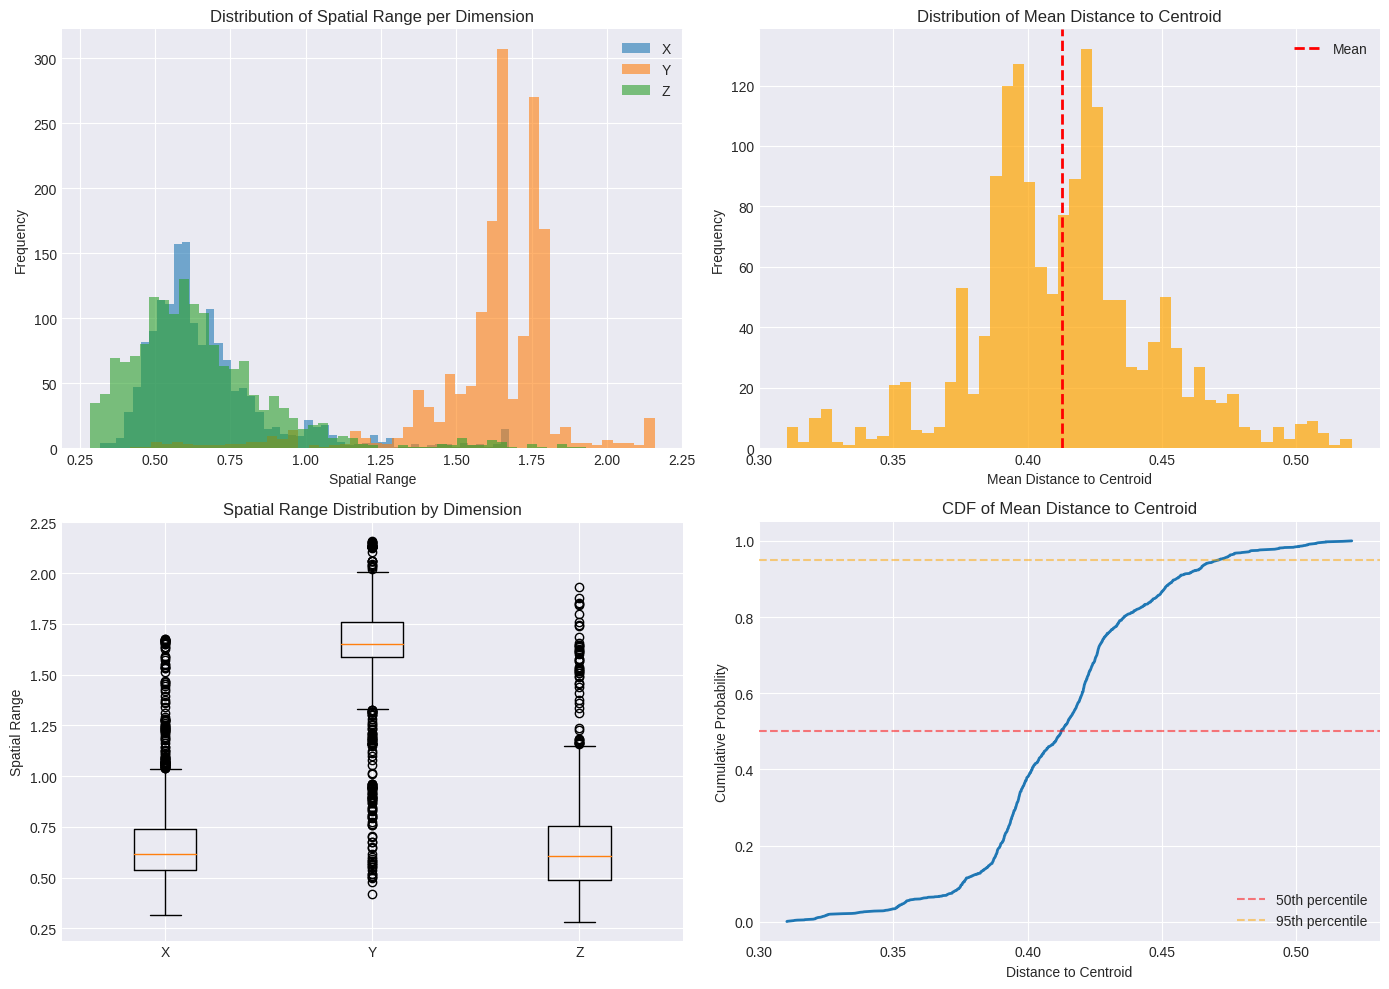


=== Recommended Radius ===
Mean distance to centroid: 0.4128
95th percentile distance: 0.4711
Suggested radius (0.1-0.2 × mean): 0.0413 - 0.0826
Suggested radius (0.1-0.2 × 95th): 0.0471 - 0.0942


In [8]:
# Visualize spatial extent distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Spatial range per dimension
for i, dim in enumerate(['X', 'Y', 'Z']):
    axes[0, 0].hist(spatial_stats['range'][:, i], bins=50, alpha=0.6, label=dim)
axes[0, 0].set_xlabel('Spatial Range')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Spatial Range per Dimension')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Distance to centroid
axes[0, 1].hist(spatial_stats['mean_distance_to_centroid'], bins=50, alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Mean Distance to Centroid')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Mean Distance to Centroid')
axes[0, 1].grid(True)
axes[0, 1].axvline(np.mean(spatial_stats['mean_distance_to_centroid']), 
                   color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 1].legend()

# Box plot of ranges
axes[1, 0].boxplot([spatial_stats['range'][:, 0], 
                     spatial_stats['range'][:, 1], 
                     spatial_stats['range'][:, 2]], 
                    labels=['X', 'Y', 'Z'])
axes[1, 0].set_ylabel('Spatial Range')
axes[1, 0].set_title('Spatial Range Distribution by Dimension')
axes[1, 0].grid(True)

# Cumulative distribution of distances
sorted_distances = np.sort(spatial_stats['mean_distance_to_centroid'])
cumulative = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)
axes[1, 1].plot(sorted_distances, cumulative, linewidth=2)
axes[1, 1].set_xlabel('Distance to Centroid')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_title('CDF of Mean Distance to Centroid')
axes[1, 1].grid(True)
axes[1, 1].axhline(0.5, color='red', linestyle='--', alpha=0.5, label='50th percentile')
axes[1, 1].axhline(0.95, color='orange', linestyle='--', alpha=0.5, label='95th percentile')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Recommended radius
mean_dist = np.mean(spatial_stats['mean_distance_to_centroid'])
percentile_95 = np.percentile(spatial_stats['mean_distance_to_centroid'], 95)
print(f"\n=== Recommended Radius ===")
print(f"Mean distance to centroid: {mean_dist:.4f}")
print(f"95th percentile distance: {percentile_95:.4f}")
print(f"Suggested radius (0.1-0.2 × mean): {0.1*mean_dist:.4f} - {0.2*mean_dist:.4f}")
print(f"Suggested radius (0.1-0.2 × 95th): {0.1*percentile_95:.4f} - {0.2*percentile_95:.4f}")

## 3. Neighbor Density Analysis

Analyze how many neighbors exist within different radii to determine optimal **nsamples** parameter.

In [9]:
# Test different radii and count neighbors
test_radii = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6]
neighbor_counts = {r: [] for r in test_radii}

num_frames_to_test = 50
sample_count = 0

print("Analyzing neighbor density for different radii...")
for idx in tqdm(sample_indices[:20]):  # Test on subset
    clip, _ = train_dataset[idx]
    
    for frame_idx in range(clip.shape[0]):
        if sample_count >= num_frames_to_test:
            break
            
        points = clip[frame_idx]
        
        # Build KD-tree
        tree = cKDTree(points)
        
        # Sample 100 random query points
        query_indices = np.random.choice(len(points), min(100, len(points)), replace=False)
        query_points = points[query_indices]
        
        # Count neighbors for each radius
        for radius in test_radii:
            for query_point in query_points:
                neighbors = tree.query_ball_point(query_point, radius)
                neighbor_counts[radius].append(len(neighbors) - 1)  # Exclude the point itself
        
        sample_count += 1
    
    if sample_count >= num_frames_to_test:
        break

# Compute statistics
neighbor_stats = {}
for radius in test_radii:
    counts = np.array(neighbor_counts[radius])
    neighbor_stats[radius] = {
        'mean': counts.mean(),
        'median': np.median(counts),
        'std': counts.std(),
        'min': counts.min(),
        'max': counts.max(),
        'percentile_25': np.percentile(counts, 25),
        'percentile_75': np.percentile(counts, 75),
        'percentile_95': np.percentile(counts, 95)
    }

print("\n=== Neighbor Count Statistics ===")
print(f"{'Radius':<8} {'Mean':<8} {'Median':<8} {'Std':<8} {'25th%':<8} {'75th%':<8} {'95th%':<8}")
print("-" * 64)
for radius in test_radii:
    stats = neighbor_stats[radius]
    print(f"{radius:<8.2f} {stats['mean']:<8.1f} {stats['median']:<8.1f} {stats['std']:<8.1f} "
          f"{stats['percentile_25']:<8.1f} {stats['percentile_75']:<8.1f} {stats['percentile_95']:<8.1f}")

Analyzing neighbor density for different radii...


 15%|█▌        | 3/20 [00:00<00:03,  5.07it/s]


=== Neighbor Count Statistics ===
Radius   Mean     Median   Std      25th%    75th%    95th%   
----------------------------------------------------------------
0.05     10.4     10.0     4.2      8.0      13.0     18.0    
0.10     45.3     43.0     13.1     36.0     52.0     71.0    
0.15     104.6    99.0     29.2     85.0     123.0    159.0   
0.20     189.9    186.0    60.0     150.0    231.0    292.0   
0.25     300.9    303.0    107.3    227.0    373.0    473.0   
0.30     437.3    447.0    163.5    321.0    549.0    689.0   
0.35     588.4    611.0    216.4    442.0    736.0    910.1   
0.40     745.0    772.0    263.4    573.0    924.0    1139.0  
0.50     1036.2   1074.0   326.8    832.8    1278.2   1501.0  
0.60     1280.4   1346.0   352.1    1053.0   1555.0   1738.0  


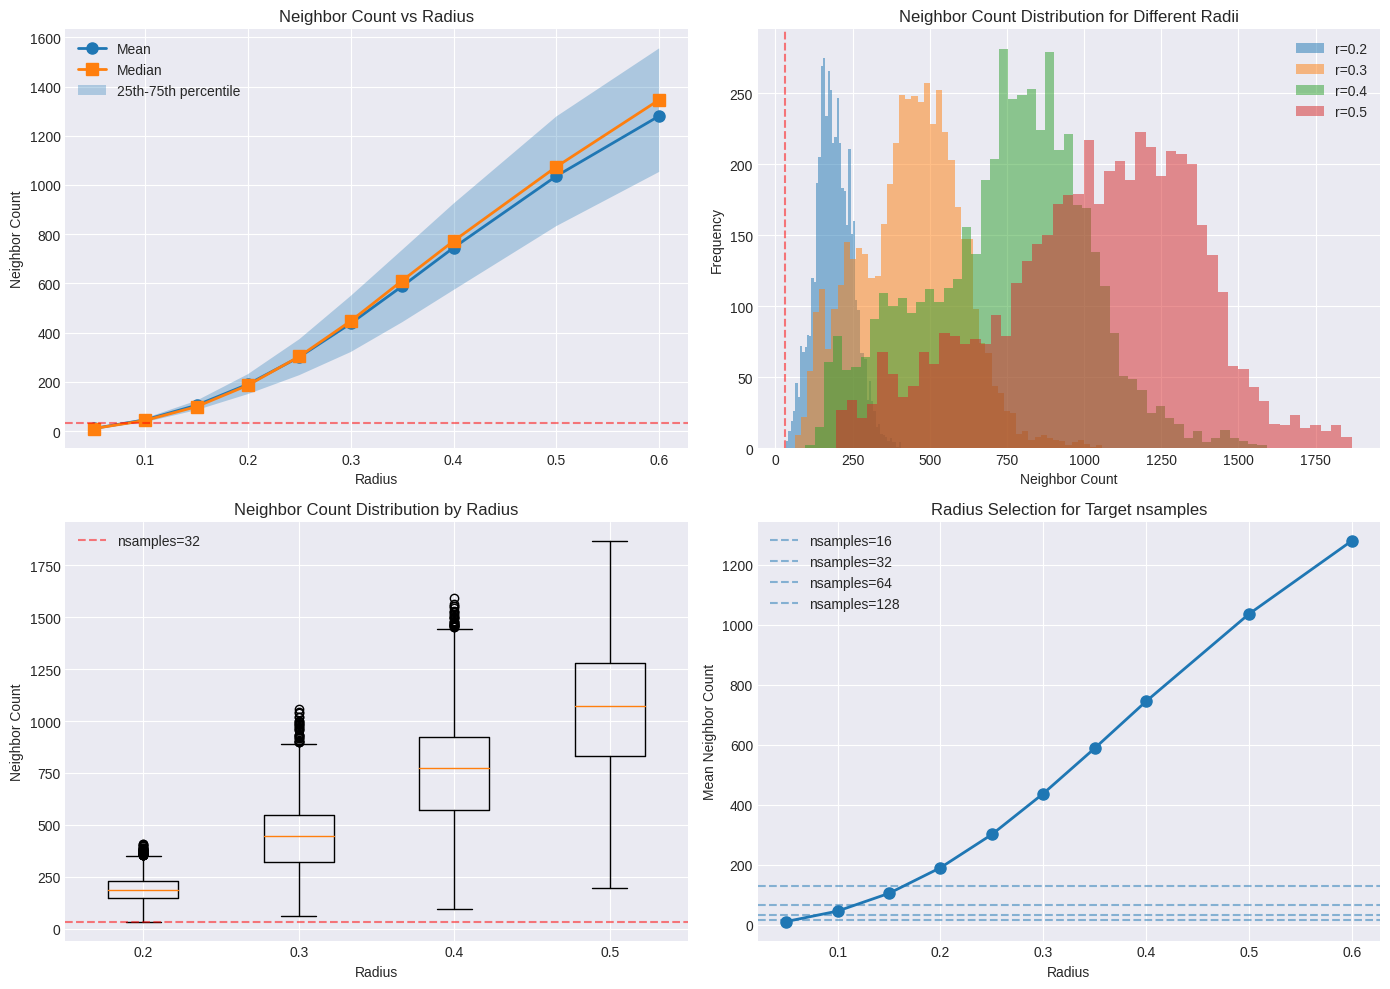


=== Recommended Radius-Nsamples Combinations ===
For nsamples=16: radius=0.05 (actual mean neighbors: 10.4)
For nsamples=32: radius=0.10 (actual mean neighbors: 45.3)
For nsamples=64: radius=0.10 (actual mean neighbors: 45.3)


In [10]:
# Visualize neighbor counts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean neighbor count vs radius
means = [neighbor_stats[r]['mean'] for r in test_radii]
medians = [neighbor_stats[r]['median'] for r in test_radii]
p25 = [neighbor_stats[r]['percentile_25'] for r in test_radii]
p75 = [neighbor_stats[r]['percentile_75'] for r in test_radii]

axes[0, 0].plot(test_radii, means, 'o-', linewidth=2, markersize=8, label='Mean')
axes[0, 0].plot(test_radii, medians, 's-', linewidth=2, markersize=8, label='Median')
axes[0, 0].fill_between(test_radii, p25, p75, alpha=0.3, label='25th-75th percentile')
axes[0, 0].set_xlabel('Radius')
axes[0, 0].set_ylabel('Neighbor Count')
axes[0, 0].set_title('Neighbor Count vs Radius')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].axhline(32, color='red', linestyle='--', alpha=0.5, label='nsamples=32')

# Distribution for selected radii
selected_radii = [0.2, 0.3, 0.4, 0.5]
for radius in selected_radii:
    if radius in neighbor_counts:
        axes[0, 1].hist(neighbor_counts[radius], bins=50, alpha=0.5, label=f'r={radius}')
axes[0, 1].set_xlabel('Neighbor Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Neighbor Count Distribution for Different Radii')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].axvline(32, color='red', linestyle='--', alpha=0.5)

# Box plot
box_data = [neighbor_counts[r] for r in selected_radii]
axes[1, 0].boxplot(box_data, labels=[f'{r}' for r in selected_radii])
axes[1, 0].set_xlabel('Radius')
axes[1, 0].set_ylabel('Neighbor Count')
axes[1, 0].set_title('Neighbor Count Distribution by Radius')
axes[1, 0].axhline(32, color='red', linestyle='--', alpha=0.5, label='nsamples=32')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Radius recommendation based on target neighbor count
target_neighbors = [16, 32, 64, 128]
axes[1, 1].plot(test_radii, means, 'o-', linewidth=2, markersize=8)
for target in target_neighbors:
    axes[1, 1].axhline(target, linestyle='--', alpha=0.5, label=f'nsamples={target}')
axes[1, 1].set_xlabel('Radius')
axes[1, 1].set_ylabel('Mean Neighbor Count')
axes[1, 1].set_title('Radius Selection for Target nsamples')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Recommend radius-nsamples combinations
print("\n=== Recommended Radius-Nsamples Combinations ===")
for target in [16, 32, 64]:
    # Find radius where mean neighbor count is closest to target
    diffs = [abs(neighbor_stats[r]['mean'] - target) for r in test_radii]
    best_radius = test_radii[np.argmin(diffs)]
    actual_mean = neighbor_stats[best_radius]['mean']
    print(f"For nsamples={target}: radius={best_radius:.2f} (actual mean neighbors: {actual_mean:.1f})")

## 4. Temporal Dynamics Analysis

Analyze motion patterns to determine optimal **temporal_stride** and **spatial_stride** parameters.

In [11]:
# Analyze temporal motion between consecutive frames
temporal_stats = {
    'frame_to_frame_displacement': [],
    'point_velocities': [],
    'centroid_displacement': []
}

num_temporal_samples = 30
print("Analyzing temporal dynamics...")

for idx in tqdm(sample_indices[:num_temporal_samples]):
    clip, _ = train_dataset[idx]  # Shape: (frames_per_clip, num_points, 3)
    
    # Compute frame-to-frame statistics
    for t in range(1, clip.shape[0]):
        prev_frame = clip[t-1]  # (num_points, 3)
        curr_frame = clip[t]    # (num_points, 3)
        
        # Compute centroid displacement
        prev_centroid = prev_frame.mean(axis=0)
        curr_centroid = curr_frame.mean(axis=0)
        centroid_disp = np.linalg.norm(curr_centroid - prev_centroid)
        temporal_stats['centroid_displacement'].append(centroid_disp)
        
        # Compute point-wise displacement (assuming correspondence)
        # Note: For unordered point clouds, this is approximate
        point_disp = np.linalg.norm(curr_frame - prev_frame, axis=1)
        temporal_stats['point_velocities'].extend(point_disp)
        temporal_stats['frame_to_frame_displacement'].append(point_disp.mean())

temporal_stats = {k: np.array(v) for k, v in temporal_stats.items()}

print("\n=== Temporal Motion Statistics ===")
print(f"Mean frame-to-frame displacement: {temporal_stats['frame_to_frame_displacement'].mean():.4f}")
print(f"Std frame-to-frame displacement: {temporal_stats['frame_to_frame_displacement'].std():.4f}")
print(f"Mean centroid displacement: {temporal_stats['centroid_displacement'].mean():.4f}")
print(f"Std centroid displacement: {temporal_stats['centroid_displacement'].std():.4f}")
print(f"Mean point velocity: {temporal_stats['point_velocities'].mean():.4f}")
print(f"95th percentile point velocity: {np.percentile(temporal_stats['point_velocities'], 95):.4f}")

Analyzing temporal dynamics...


100%|██████████| 30/30 [00:00<00:00, 46.01it/s]


=== Temporal Motion Statistics ===
Mean frame-to-frame displacement: 0.3386
Std frame-to-frame displacement: 0.2435
Mean centroid displacement: 0.0375
Std centroid displacement: 0.0461
Mean point velocity: 0.3386
95th percentile point velocity: 1.0801


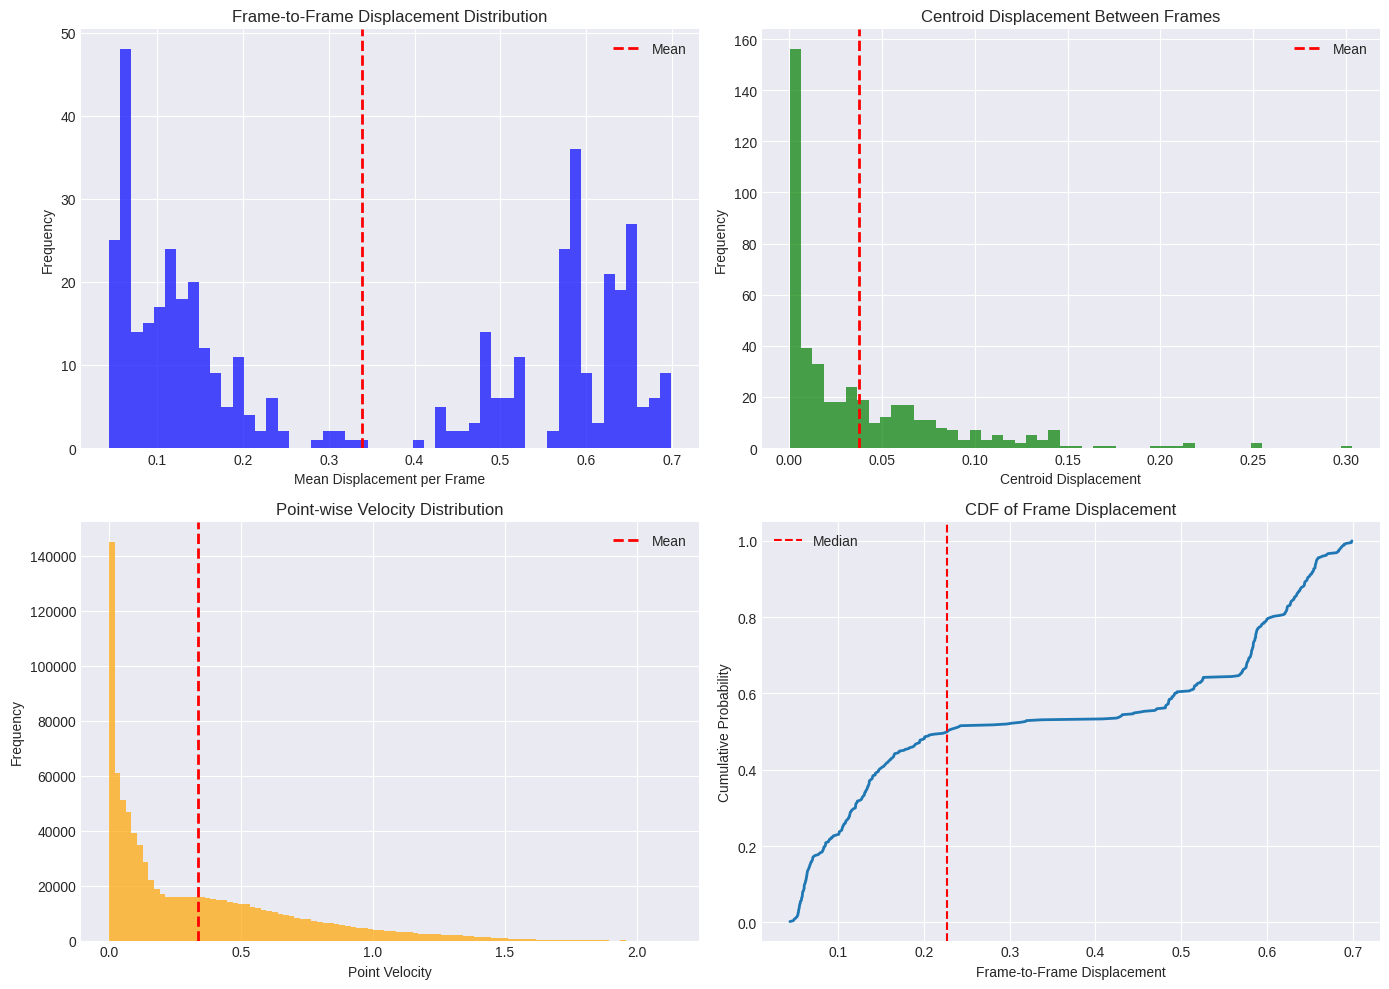


=== Temporal Stride Recommendations ===
Average motion per frame: 0.3386
If motion is LOW (< 0.05): temporal_stride = 1-2 (capture fine motion)
If motion is MEDIUM (0.05-0.2): temporal_stride = 2-3 (balance detail/efficiency)
If motion is HIGH (> 0.2): temporal_stride = 3-4 (reduce redundancy)

Based on data (mean=0.3386):
  → Recommended temporal_stride: 3-4


In [12]:
# Visualize temporal dynamics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Frame-to-frame displacement distribution
axes[0, 0].hist(temporal_stats['frame_to_frame_displacement'], bins=50, alpha=0.7, color='blue')
axes[0, 0].set_xlabel('Mean Displacement per Frame')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Frame-to-Frame Displacement Distribution')
axes[0, 0].axvline(temporal_stats['frame_to_frame_displacement'].mean(), 
                   color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Centroid displacement
axes[0, 1].hist(temporal_stats['centroid_displacement'], bins=50, alpha=0.7, color='green')
axes[0, 1].set_xlabel('Centroid Displacement')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Centroid Displacement Between Frames')
axes[0, 1].axvline(temporal_stats['centroid_displacement'].mean(), 
                   color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Point velocity distribution
axes[1, 0].hist(temporal_stats['point_velocities'], bins=100, alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Point Velocity')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Point-wise Velocity Distribution')
axes[1, 0].axvline(temporal_stats['point_velocities'].mean(), 
                   color='red', linestyle='--', linewidth=2, label='Mean')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Cumulative distribution
sorted_disp = np.sort(temporal_stats['frame_to_frame_displacement'])
cumulative = np.arange(1, len(sorted_disp) + 1) / len(sorted_disp)
axes[1, 1].plot(sorted_disp, cumulative, linewidth=2)
axes[1, 1].set_xlabel('Frame-to-Frame Displacement')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_title('CDF of Frame Displacement')
axes[1, 1].grid(True)
axes[1, 1].axvline(np.median(sorted_disp), color='red', linestyle='--', label='Median')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Motion characteristics
mean_motion = temporal_stats['frame_to_frame_displacement'].mean()
std_motion = temporal_stats['frame_to_frame_displacement'].std()

print("\n=== Temporal Stride Recommendations ===")
print(f"Average motion per frame: {mean_motion:.4f}")
print(f"If motion is LOW (< 0.05): temporal_stride = 1-2 (capture fine motion)")
print(f"If motion is MEDIUM (0.05-0.2): temporal_stride = 2-3 (balance detail/efficiency)")
print(f"If motion is HIGH (> 0.2): temporal_stride = 3-4 (reduce redundancy)")
print(f"\nBased on data (mean={mean_motion:.4f}):")
if mean_motion < 0.05:
    print("  → Recommended temporal_stride: 1-2")
elif mean_motion < 0.2:
    print("  → Recommended temporal_stride: 2-3")
else:
    print("  → Recommended temporal_stride: 3-4")

## 5. Point Density Analysis

Analyze point cloud density to determine optimal **spatial_stride** parameter.

In [13]:
# Analyze point density
density_stats = []

print("Analyzing point density...")
for idx in tqdm(sample_indices[:30]):
    clip, _ = train_dataset[idx]
    
    for frame_idx in range(clip.shape[0]):
        points = clip[frame_idx]
        
        # Compute bounding box volume
        min_coords = points.min(axis=0)
        max_coords = points.max(axis=0)
        ranges = max_coords - min_coords
        volume = np.prod(ranges)
        
        if volume > 0:
            density = len(points) / volume
            density_stats.append(density)

density_stats = np.array(density_stats)

print("\n=== Point Density Statistics ===")
print(f"Mean density (points/volume): {density_stats.mean():.2f}")
print(f"Median density: {np.median(density_stats):.2f}")
print(f"Std density: {density_stats.std():.2f}")

# Compute effective sampling given different spatial strides
current_points = train_dataset.num_points
print(f"\nCurrent points per frame: {current_points}")
print("\n=== Spatial Stride Impact ===")
for stride in [16, 32, 64, 128]:
    effective_points = current_points // stride
    print(f"spatial_stride={stride:3d} → ~{effective_points:4d} points after downsampling")

Analyzing point density...


100%|██████████| 30/30 [00:00<00:00, 47.89it/s]


=== Point Density Statistics ===
Mean density (points/volume): 3597.77
Median density: 3522.54
Std density: 1551.95

Current points per frame: 2048

=== Spatial Stride Impact ===
spatial_stride= 16 → ~ 128 points after downsampling
spatial_stride= 32 → ~  64 points after downsampling
spatial_stride= 64 → ~  32 points after downsampling
spatial_stride=128 → ~  16 points after downsampling


## 6. Final Hyperparameter Recommendations

Based on the analysis above, here are the recommended hyperparameters for your training configuration.

In [14]:
print("="*70)
print(" RECOMMENDED HYPERPARAMETERS FOR UST MODEL")
print("="*70)

# Get actual statistics
mean_dist = np.mean(spatial_stats['mean_distance_to_centroid'])
mean_motion = temporal_stats['frame_to_frame_displacement'].mean()

# Recommend radius based on mean distance
recommended_radius = round(0.15 * mean_dist, 2)

# Recommend nsamples based on radius
best_nsamples = 32
for target in [16, 32, 64]:
    diffs = [abs(neighbor_stats[r]['mean'] - target) for r in test_radii if r <= recommended_radius * 1.5]
    if diffs:
        best_radius_for_target = [r for r in test_radii if r <= recommended_radius * 1.5][np.argmin(diffs)]
        if abs(best_radius_for_target - recommended_radius) < 0.1:
            best_nsamples = target
            break

# Recommend temporal stride
if mean_motion < 0.05:
    rec_temporal_stride = 2
elif mean_motion < 0.2:
    rec_temporal_stride = 2
else:
    rec_temporal_stride = 3

# Recommend spatial stride
rec_spatial_stride = 32  # Standard choice for 2048 points

print(f"""
SPATIAL PARAMETERS:
-------------------
radius:           {recommended_radius:.2f}
  (Based on {100*0.15:.0f}% of mean distance to centroid: {mean_dist:.4f})
  
nsamples:         {best_nsamples}
  (Target neighbors within radius {recommended_radius:.2f})
  
spatial_stride:   {rec_spatial_stride}
  (Reduces {train_dataset.num_points} points → ~{train_dataset.num_points//rec_spatial_stride} effective points)

TEMPORAL PARAMETERS:
--------------------
temporal_stride:  {rec_temporal_stride}
  (Based on mean frame motion: {mean_motion:.4f})
  
temporal_kernel_size: 3
  (Standard for capturing local temporal context)

frames_per_clip:  {train_dataset.frames_per_clip}
  (Current setting)

COMPARISON WITH CURRENT CONFIG:
-------------------------------
Current radius:           0.3
Recommended radius:       {recommended_radius:.2f}

Current nsamples:         32
Recommended nsamples:     {best_nsamples}

Current spatial_stride:   32
Recommended spatial_stride: {rec_spatial_stride}

Current temporal_stride:  2
Recommended temporal_stride: {rec_temporal_stride}

SUGGESTED CONFIG FOR humanml_train.py:
--------------------------------------
""")

print("model_params = {")
print(f"    'radius': {recommended_radius},")
print(f"    'nsamples': {best_nsamples},")
print(f"    'spatial_stride': {rec_spatial_stride},")
print(f"    'temporal_kernel_size': 3,")
print(f"    'temporal_stride': {rec_temporal_stride},")
print("    'dim': 160,")
print("    'heads': 6,")
print("    'mlp_dim': 320,")
print("    'num_classes': 20,")
print("    'dropout': 0.0,")
print("    'depth': 1,")
print("    'hos_branches_num': 3,")
print("    'encoder_channel': 60")
print("}")

print("\n" + "="*70)

 RECOMMENDED HYPERPARAMETERS FOR UST MODEL

SPATIAL PARAMETERS:
-------------------
radius:           0.06
  (Based on 15% of mean distance to centroid: 0.4128)
  
nsamples:         16
  (Target neighbors within radius 0.06)
  
spatial_stride:   32
  (Reduces 2048 points → ~64 effective points)

TEMPORAL PARAMETERS:
--------------------
temporal_stride:  3
  (Based on mean frame motion: 0.3386)
  
temporal_kernel_size: 3
  (Standard for capturing local temporal context)

frames_per_clip:  16
  (Current setting)

COMPARISON WITH CURRENT CONFIG:
-------------------------------
Current radius:           0.3
Recommended radius:       0.06

Current nsamples:         32
Recommended nsamples:     16

Current spatial_stride:   32
Recommended spatial_stride: 32

Current temporal_stride:  2
Recommended temporal_stride: 3

SUGGESTED CONFIG FOR humanml_train.py:
--------------------------------------

model_params = {
    'radius': 0.06,
    'nsamples': 16,
    'spatial_stride': 32,
    'temporal_

## 7. Visualization: Sample Point Cloud

Visualize a sample sequence to understand the data structure.

Caption: a person falls to the ground in a sitting motion and then pops back up in a standing position
Clip shape: (16, 2048, 3)


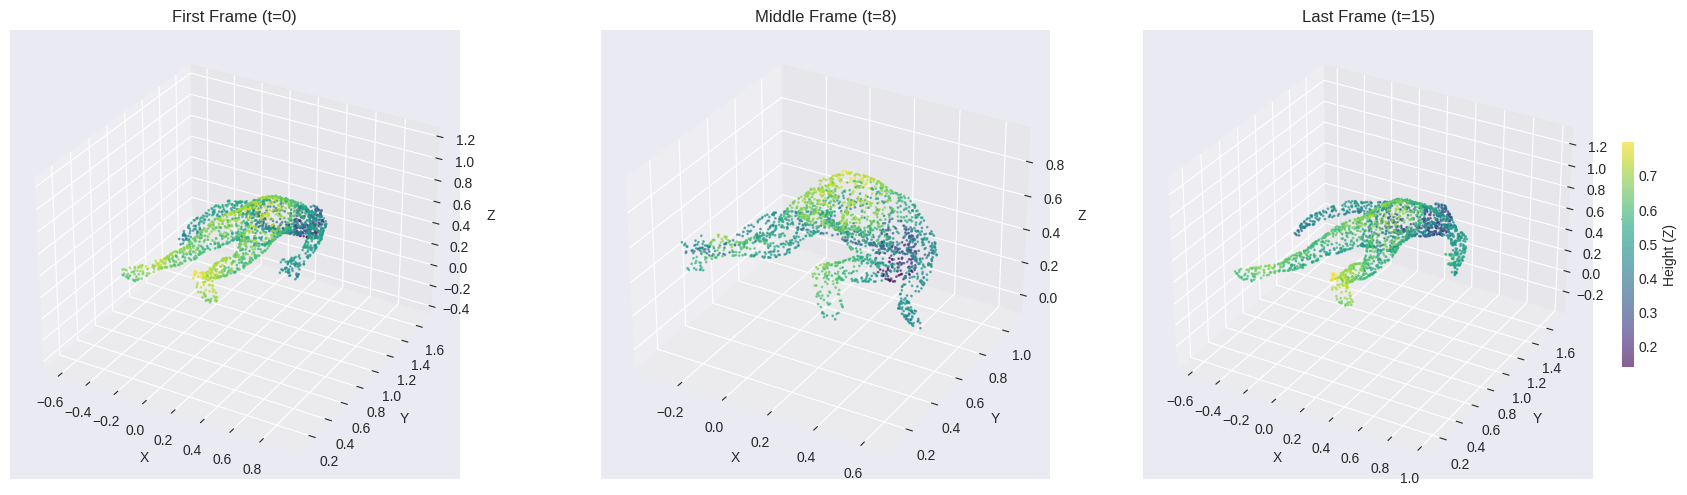

In [15]:
# Visualize a sample sequence
sample_idx = 0
clip, caption = train_dataset[sample_idx]

print(f"Caption: {caption}")
print(f"Clip shape: {clip.shape}")

# Plot first, middle, and last frames
fig = plt.figure(figsize=(18, 5))

frames_to_plot = [0, clip.shape[0]//2, clip.shape[0]-1]
titles = ['First Frame', 'Middle Frame', 'Last Frame']

for i, (frame_idx, title) in enumerate(zip(frames_to_plot, titles)):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    points = clip[frame_idx]
    
    # Color by height (Z coordinate)
    colors = points[:, 2]
    
    scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
                        c=colors, cmap='viridis', s=1, alpha=0.6)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'{title} (t={frame_idx})')
    
    # Set equal aspect ratio
    max_range = np.array([points[:, 0].max()-points[:, 0].min(),
                         points[:, 1].max()-points[:, 1].min(),
                         points[:, 2].max()-points[:, 2].min()]).max() / 2.0
    
    mid_x = (points[:, 0].max()+points[:, 0].min()) * 0.5
    mid_y = (points[:, 1].max()+points[:, 1].min()) * 0.5
    mid_z = (points[:, 2].max()+points[:, 2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.colorbar(scatter, ax=ax, label='Height (Z)', shrink=0.5)
plt.tight_layout()
plt.show()